# Binarynet CIFAR10 Example

In this example we demonstrate how to use xquant to build binarynet with CIFAR10. Note that we only train for 10 epochs due to cost, so customise to your available resources/time! (On a Nvidia GTX1050ti MaxQ one epoch takes around 2 minutes, and on V100 one epoch takes 80 seconds)

## Import Modules

First we import the modules, noting that in this example we DO NOT use tensorflow_datasets. We use tensorflow, keras and xquant

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import xquant as xq
import numpy as np
import matplotlib.pyplot as plt

## Import CIFAR10 Dataset

We download and normalize the CIFAR10 dataset 

In [2]:
num_classes = 10

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_images = train_images.reshape((50000, 32, 32, 3))
test_images = test_images.reshape((10000, 32, 32, 3))

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Normalize pixel values to be between -1 and 1
train_images, test_images = (train_images / (255.0/2.0))-1., (test_images / (255.0/2.0))-1.

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

We impliment ZCA whitening as per original paper

In [3]:
#datagen_train = ImageDataGenerator(zca_whitening=True)
#datagen_test = ImageDataGenerator(zca_whitening=True)
#datagen_train.fit(train_images)
#datagen_test.fit(test_images)

## Build Binarynet

In [4]:
model = tf.keras.models.Sequential(
    [
        xq.layers.QuantConv2D(
            128,
            3,
            kernel_quantizer="ste_sign",
            use_bias=False,
            kernel_constraint="weight_clip",
            input_shape=(32, 32, 3),
        ),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
        tf.keras.layers.Activation("hard_tanh"),
        xq.layers.QuantConv2D(
            128,
            3,
            kernel_quantizer="ste_sign",
            input_quantizer="ste_sign",
            kernel_constraint="weight_clip",
            padding="same",
            use_bias=False,
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
        tf.keras.layers.Activation("hard_tanh"),
        xq.layers.QuantConv2D(
            256,
            3,
            kernel_quantizer="ste_sign",
            input_quantizer="ste_sign",
            kernel_constraint="weight_clip",
            padding="same",
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
        tf.keras.layers.Activation("hard_tanh"),
        xq.layers.QuantConv2D(
            256,
            3,
            kernel_quantizer="ste_sign",
            input_quantizer="ste_sign",
            kernel_constraint="weight_clip",
            padding="same",
            use_bias=False,
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
        tf.keras.layers.Activation("hard_tanh"),
        xq.layers.QuantConv2D(
            512,
            3,
            kernel_quantizer="ste_sign",
            input_quantizer="ste_sign",
            kernel_constraint="weight_clip",
            padding="same",
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
        tf.keras.layers.Activation("hard_tanh"),
        xq.layers.QuantConv2D(
            512,
            3,
            kernel_quantizer="ste_sign",
            input_quantizer="ste_sign",
            kernel_constraint="weight_clip",
            padding="same",
            use_bias=False,
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Activation("hard_tanh"),
        xq.layers.QuantDense(
            1024,
            kernel_quantizer="ste_sign",
            input_quantizer="ste_sign",
            kernel_constraint="weight_clip",
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
        tf.keras.layers.Activation("hard_tanh"),
        xq.layers.QuantDense(
            1024,
            kernel_quantizer="ste_sign",
            input_quantizer="ste_sign",
            kernel_constraint="weight_clip",
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
        tf.keras.layers.Activation("hard_tanh"),
        xq.layers.QuantDense(
            10,
            kernel_quantizer="ste_sign",
            input_quantizer="ste_sign",
            kernel_constraint="weight_clip",
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
        tf.keras.layers.Activation("softmax"),
    ]
)


Optionally one can output a summary of the model. Commented out by default

In [5]:
#model.summary()

## Model Training

We train the model. First we define some useful things

Define a learning rate with exponential decay and make it a 'Keras Callback'

In [6]:
def exponential_learning_rate(epoch):
    LR_start = 0.001
    LR_fin = 0.0000003
    num_epochs = 500.
    LR_decay = (LR_fin/LR_start)**(1./num_epochs)
    lrate = LR_start*pow(LR_decay,epoch)
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(exponential_learning_rate)

We next create a 'UsefulTracking' class such that we can make some plots later

In [7]:
class UsefulTracking(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.learning_rate_custom = []
    def on_epoch_end(self, epoch, logs=None):
        #Optional learning rate print statement
        #print(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.learning_rate_custom.append(tf.keras.backend.get_value(self.model.optimizer.lr))

useful_tracking=UsefulTracking()
        

Compile the model and train the model

In [8]:
model.compile(
    xq.optimizers.XavierLearningRateScaling(model,tf.keras.optimizers.Adam,lr=0.001,decay=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [9]:
trained_model=model.fit(
    train_images, 
    train_labels,
    batch_size=50, 
    epochs=2,
    validation_data=(test_images, test_labels),
    shuffle=True
)

#trained_model=model.fit(
#    datagen_train.flow(train_images, train_labels,batch_size=50), 
#    epochs=20,
#    validation_data=(datagen_test.flow(test_images, test_labels,batch_size=50)),
#    shuffle=True,
#    callbacks=[useful_tracking,lrate]
#)

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 130s 3ms/step - loss: 1.9345 - acc: 0.2973 - val_loss: 2.0544 - val_acc: 0.2575
Epoch 2/2
50000/50000 [==============================] - 127s 3ms/step - loss: 1.8708 - acc: 0.3268 - val_loss: 1.8536 - val_acc: 0.3299


## Model Output

We now plot a few useful things

0.3268000013753772
0.3299000010639429


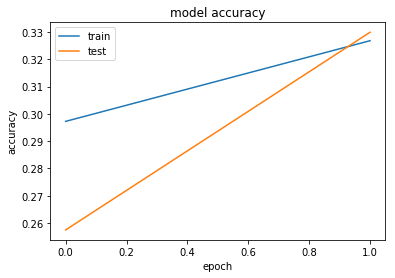

In [10]:
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.max(trained_model.history['acc']))
print(np.max(trained_model.history['val_acc']))

1.8708452563285827
1.8536240863800049


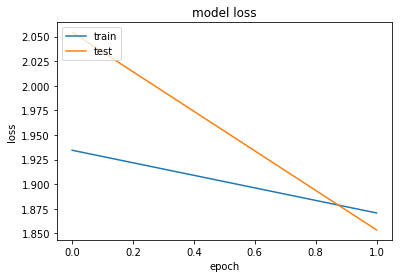

In [11]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.min(trained_model.history['loss']))
print(np.min(trained_model.history['val_loss']))

In [12]:
#plt.plot(useful_tracking.learning_rate_custom)
#plt.title('model learning rate')
#plt.yscale('log')
#plt.ylabel('learning rate')
#plt.xlabel('epoch')
#print(np.max(useful_tracking.learning_rate_custom))
#print(np.min(useful_tracking.learning_rate_custom))